# Sistema de recomendación basado en modelos de regresión para la optimización de solicitudes de viajes en Uber

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import geopy.distance
from tqdm import tqdm
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Data frame 1. Uber rides Dataset w/o weather

In [3]:
df = pd.read_csv('./dataset/uber.csv')
df

Unnamed: 0                            key  fare_amount  \
0         24238194    2015-05-07 19:52:06.0000003          7.5   
1         27835199    2009-07-17 20:04:56.0000002          7.7   
2         44984355   2009-08-24 21:45:00.00000061         12.9   
3         25894730    2009-06-26 08:22:21.0000001          5.3   
4         17610152  2014-08-28 17:47:00.000000188         16.0   
...            ...                            ...          ...   
199995    42598914   2012-10-28 10:49:00.00000053          3.0   
199996    16382965    2014-03-14 01:09:00.0000008          7.5   
199997    27804658   2009-06-29 00:42:00.00000078         30.9   
199998    20259894    2015-05-20 14:56:25.0000004         14.5   
199999    11951496   2010-05-15 04:08:00.00000076         14.1   

                pickup_datetime  pickup_longitude  pickup_latitude  \
0       2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1       2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2       2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3       2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4       2014-08-28 17:47:00 UTC        -73.925023        40.744085   
...                         ...               ...              ...   
199995  2012-10-28 10:49:00 UTC        -73.987042        40.739367   
199996  2014-03-14 01:09:00 UTC        -73.984722        40.736837   
199997  2009-06-29 00:42:00 UTC        -73.986017        40.756487   
199998  2015-05-20 14:56:25 UTC        -73.997124        40.725452   
199999  2010-05-15 04:08:00 UTC        -73.984395        40.720077   

        dropoff_longitude  dropoff_latitude  passenger_count  
0              -73.999512         40.723217                1  
1              -73.994710         40.750325                1  
2              -73.962565         40.772647                1  
3              -73.965316         40.803349                3  
4              -73.973082         40.761247                5  
...                   ...               ...              ...  
199995         -73.986525         40.740297                1  
199996         -74.006672         40.739620                1  
199997         -73.858957         40.692588                2  
199998         -73.983215         40.695415                1  
199999         -73.985508         40.768793                1  

[200000 rows x 9 columns]

In [4]:
df.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


### Drop Unnamed & Key

In [6]:
df.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)
display(df.head())

fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1          7.7  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2         12.9  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3          5.3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4         16.0  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5

In [7]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [8]:
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

In [9]:
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})


Month Quarters: Meses del año divididos en cuartos

Q1
* Enero
* Febrero
* Marzo

Q2
* Abril
* Mayo
* Junio

Q3
* Julio
* Agosto
* Septiembre

Q4
* Octubre
* Noviembre
* Diciembre



Hour Segments: Segmentos de Hora para hacer la selección de horas del día de forma más sencilla. (La hora se cuenta 00:00:00 (HH:MM:SS) hasta 00:59:59 (HH:MM:SS)

**H1:** Las horas de la madrugada. **00:00 AM - 03:59 AM**

**H2:** Las horas de tarde madrugada y temprana mañana. **04:00 AM - 07:59 AM**

**H3**: Las horas de la mañana. **08:00 AM - 11:59 AM**

**H4**: Las horas del medio dia y tarde temprana. **12:00 PM - 03:59 PM**

**H5**: Las horas de la tarde. **04:00 PM - 07:59 PM**

**H6**: Las horas de tarde noche. **08:00 PM - 11:59 PM.**

In [10]:
# Distancia medida en metros.

df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

In [11]:
df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude  passenger_count  year  weekday Monthly_Quarter  \
0         40.723217                1  2015        3              Q2   
1         40.750325                1  2009        4              Q3   
2         40.772647                1  2009        0              Q3   
3         40.803349                3  2009        4              Q2   
4         40.761247                5  2014        3              Q3   

  Hourly_Segments  Distance  
0              H5   1681.11  
1              H6   2454.36  
2              H6   5039.60  
3              H3   1661.44  
4              H5   4483.73

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199987 non-null  float64
 4   dropoff_latitude   199987 non-null  float64
 5   passenger_count    199987 non-null  int64  
 6   year               199987 non-null  int64  
 7   weekday            199987 non-null  int64  
 8   Monthly_Quarter    199987 non-null  object 
 9   Hourly_Segments    199987 non-null  object 
 10  Distance           199987 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 22.3+ MB


In [13]:
null_values = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
null_values['Percentage'] = round(null_values['Total Null Values']/df.shape[0],3)*100
print(null_values)
df.dropna(inplace=True)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
dropoff_longitude                  0         0.0
dropoff_latitude                   0         0.0
passenger_count                    0         0.0
year                               0         0.0
weekday                            0         0.0
Monthly_Quarter                    0         0.0
Hourly_Segments                    0         0.0
Distance                           0         0.0


In [14]:
df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71055
dropoff_longitude     76890
pickup_latitude       83831
dropoff_latitude      90582
Distance             164542
dtype: int64

In [15]:
nu = df.drop(['fare_amount'], axis=1).nunique().sort_values() #unique rows
nf = []; cf = []; nnf = 0; ncf = 0; # numerical & categorical columns

for i in range(df.drop(['fare_amount'], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('Columnas Numericas: {}\nColumnas Categoricas: {}'.format(len(nf),len(cf)))

Columnas Numericas: 5
Columnas Categoricas: 5


In [16]:
display(df.describe())

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  199987.000000     199987.000000    199987.000000      199987.000000   
mean       11.359849        -72.501786        39.917937         -72.511608   
std         9.901868         10.449955         6.130412          10.412192   
min       -52.000000        -93.824668       -74.015515         -75.458979   
25%         6.000000        -73.992064        40.734793         -73.991407   
50%         8.500000        -73.981822        40.752592         -73.980092   
75%        12.500000        -73.967154        40.767157         -73.963658   
max       499.000000         40.808425        48.018760          40.831932   

       dropoff_latitude  passenger_count           year        weekday  \
count     199987.000000    199987.000000  199987.000000  199987.000000   
mean          39.922031         1.684544    2011.742463       3.048383   
std            6.117669         1.385999       1.856438       1.946960   
min          -74.015750         0.000000    2009.000000       0.000000   
25%           40.733823         1.000000    2010.000000       1.000000   
50%           40.753042         1.000000    2012.000000       3.000000   
75%           40.768000         2.000000    2013.000000       5.000000   
max           45.031598       208.000000    2015.000000       6.000000   

           Distance  
count  1.999870e+05  
mean   2.056346e+04  
std    3.796638e+05  
min    0.000000e+00  
25%    1.215530e+03  
50%    2.121280e+03  
75%    3.874255e+03  
max    8.783594e+06

In [17]:
df

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               7.5        -73.999817        40.738354         -73.999512   
1               7.7        -73.994355        40.728225         -73.994710   
2              12.9        -74.005043        40.740770         -73.962565   
3               5.3        -73.976124        40.790844         -73.965316   
4              16.0        -73.925023        40.744085         -73.973082   
...             ...               ...              ...                ...   
199995          3.0        -73.987042        40.739367         -73.986525   
199996          7.5        -73.984722        40.736837         -74.006672   
199997         30.9        -73.986017        40.756487         -73.858957   
199998         14.5        -73.997124        40.725452         -73.983215   
199999         14.1        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  year  weekday Monthly_Quarter  \
0              40.723217                1  2015        3              Q2   
1              40.750325                1  2009        4              Q3   
2              40.772647                1  2009        0              Q3   
3              40.803349                3  2009        4              Q2   
4              40.761247                5  2014        3              Q3   
...                  ...              ...   ...      ...             ...   
199995         40.740297                1  2012        6              Q4   
199996         40.739620                1  2014        4              Q1   
199997         40.692588                2  2009        0              Q2   
199998         40.695415                1  2015        2              Q2   
199999         40.768793                1  2010        5              Q2   

       Hourly_Segments  Distance  
0                   H5   1681.11  
1                   H6   2454.36  
2                   H6   5039.60  
3                   H3   1661.44  
4                   H5   4483.73  
...                ...       ...  
199995              H3    112.13  
199996              H1   1879.64  
199997              H1  12867.92  
199998              H4   3536.55  
199999              H2   5410.68  

[199987 rows x 11 columns]

                                     Variables Categoricas:                                     


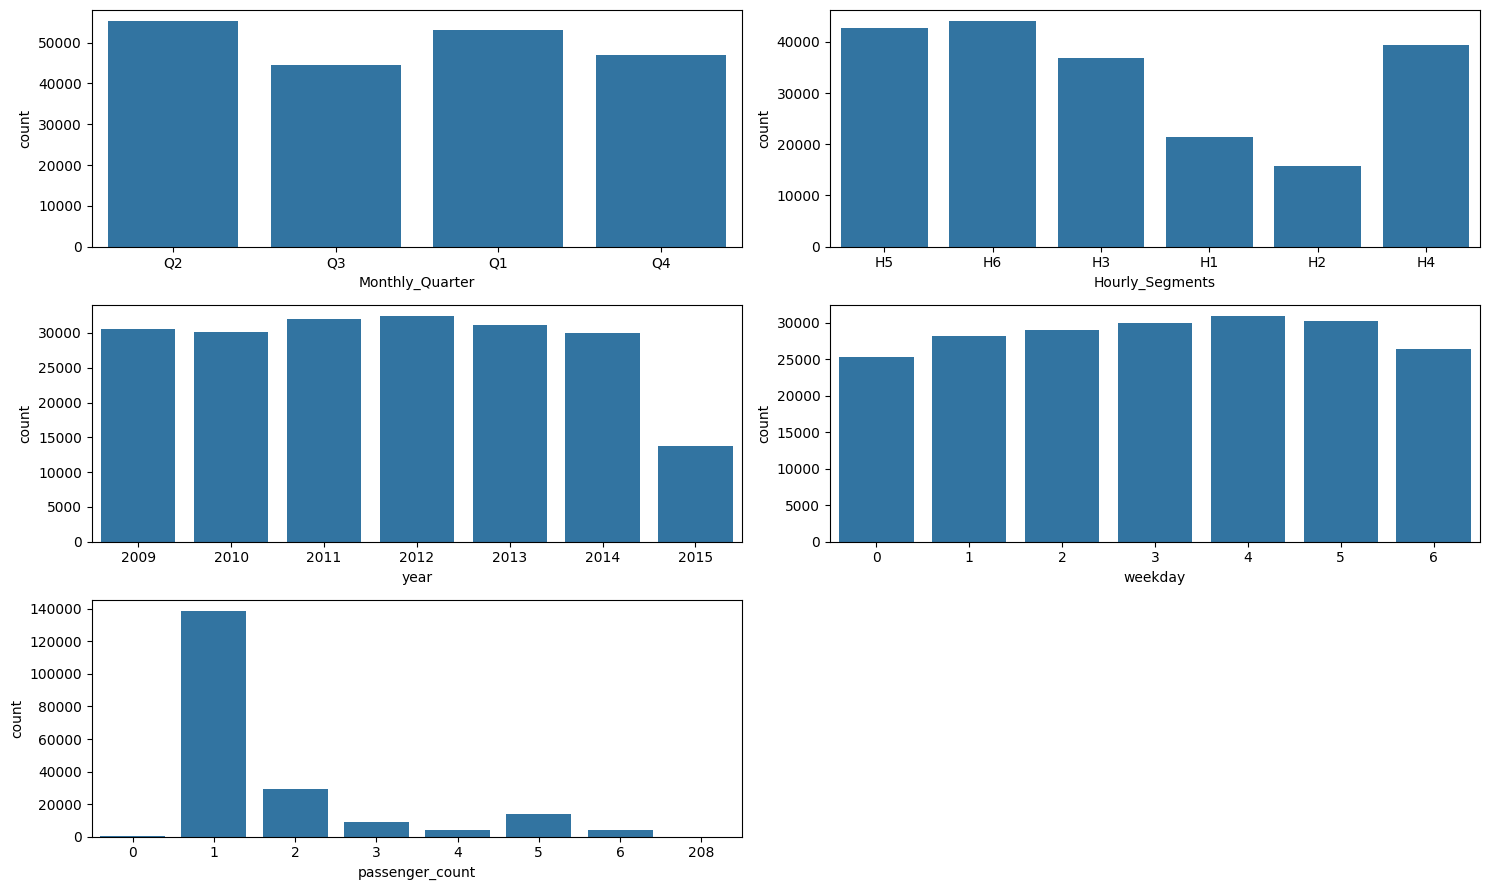

In [18]:
print('\033[1mVariables Categoricas:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(x=df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])

plt.tight_layout()
plt.show()

                                      Variables Numericas                                       


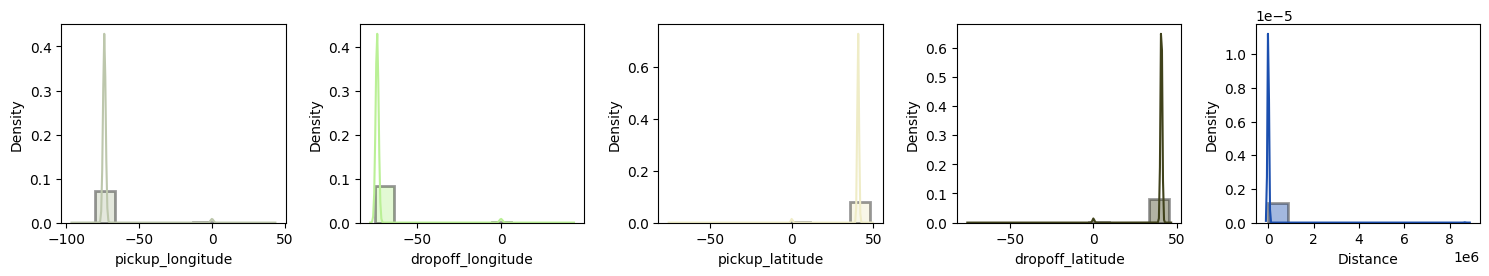

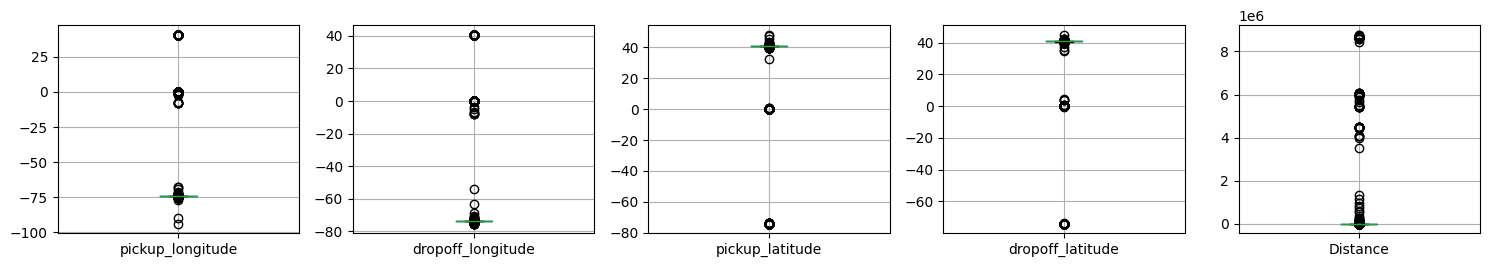

In [19]:
#Visualizar variables numericas

print('\033[1mVariables Numericas'.center(100))

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

**Preprocesamiento del Dataset**

In [19]:
# Remover duplicados
rows, cols = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

if df.shape==(rows, cols):
  print("Sin duplicados")
else:
  print(f'Duplicados eliminados: {rows-df.shape[0]}')

Duplicados eliminados: 109


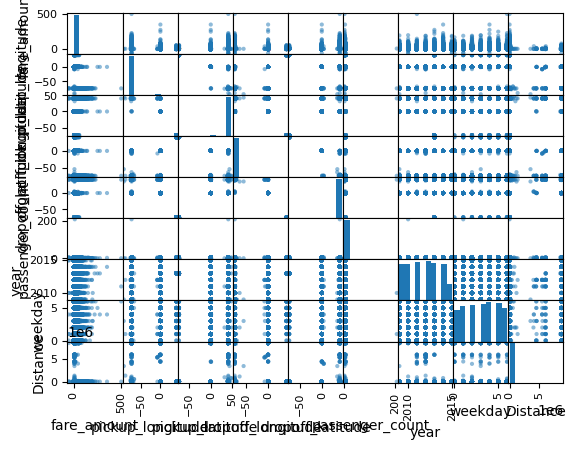

In [21]:
############# NO CORRER ESTA CLEDA
pd.plotting.scatter_matrix(df);

In [20]:
# Convertir variables Categoricas a numericas

df1 = df.copy()
df3 = df1.copy()

ecc = null_values[null_values['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

#One-Hot Binary
oh=1
dm=1
for i in fcc:
    if df3[i].nunique()==2:
        if oh==1: print("\033[1mOne-Hot Binary en variables:\033[0m")
        print(i);oh=0
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==1: print("\n\033[1mDummies en variables:\033[0m")
        print(i);dm=0
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape


Dummies en variables:
Monthly_Quarter
Hourly_Segments
year
weekday
passenger_count


(199878, 33)

In [22]:
display(df3.head())

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude  Distance  Monthly_Quarter_Q2  Monthly_Quarter_Q3  \
0         40.723217   1681.11                   1                   0   
1         40.750325   2454.36                   0                   1   
2         40.772647   5039.60                   0                   1   
3         40.803349   1661.44                   1                   0   
4         40.761247   4483.73                   0                   1   

   Monthly_Quarter_Q4  Hourly_Segments_H2  ...  weekday_4  weekday_5  \
0                   0                   0  ...          0          0   
1                   0                   0  ...          1          0   
2                   0                   0  ...          0          0   
3                   0                   0  ...          1          0   
4                   0                   0  ...          0          0   

   weekday_6  passenger_count_1  passenger_count_2  passenger_count_3  \
0          0                  1                  0                  0   
1          0                  1                  0                  0   
2          0                  1                  0                  0   
3          0                  0                  0                  1   
4          0                  0                  0                  0   

   passenger_count_4  passenger_count_5  passenger_count_6  \
0                  0                  0                  0   
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  1                  0   

   passenger_count_208  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 33 columns]

In [23]:
df3.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'Distance',
       'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4',
       'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4',
       'Hourly_Segments_H5', 'Hourly_Segments_H6', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'passenger_count_208'],
      dtype='object')

In [24]:
#Remover Atipicos:

df1 = df3.copy()

variables = nf

for i in variables:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInferencia:\033[0m\nCon valores atipicos, Dataset: {}.'.format(df3.shape[0]))
print('Atipicos removidos, Dataset: {}.'.format(df1.shape[0]))



fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4          4.9        -73.969019        40.755910         -73.969019   

   dropoff_latitude  Distance  Monthly_Quarter_Q2  Monthly_Quarter_Q3  \
0         40.723217   1681.11                   1                   0   
1         40.750325   2454.36                   0                   1   
2         40.772647   5039.60                   0                   1   
3         40.803349   1661.44                   1                   0   
4         40.755910      0.00                   0                   0   

   Monthly_Quarter_Q4  Hourly_Segments_H2  ...  weekday_4  weekday_5  \
0                   0                   0  ...          0          0   
1                   0                   0  ...          1          0   
2                   0                   0  ...          0          0   
3                   0                   0  ...          1          0   
4                   0                   0  ...          0          1   

   weekday_6  passenger_count_1  passenger_count_2  passenger_count_3  \
0          0                  1                  0                  0   
1          0                  1                  0                  0   
2          0                  1                  0                  0   
3          0                  0                  0                  1   
4          0                  1                  0                  0   

   passenger_count_4  passenger_count_5  passenger_count_6  \
0                  0                  0                  0   
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  0                  0   

   passenger_count_208  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 33 columns]


Inferencia:
Con valores atipicos, Dataset: 199878.
Atipicos removidos, Dataset: 163203.


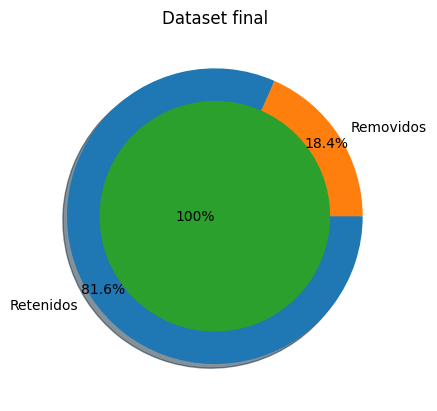

In [25]:
# Dataset Final

# df = df1.copy()
df1.columns=[i.replace('-','_') for i in df1.columns]

plt.title('Dataset final')
plt.pie([df1.shape[0], original_df.shape[0]-df1.shape[0]], radius = 1, labels=['Retenidos','Removidos'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df1.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199878 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199878 non-null  float64
 1   pickup_longitude   199878 non-null  float64
 2   pickup_latitude    199878 non-null  float64
 3   dropoff_longitude  199878 non-null  float64
 4   dropoff_latitude   199878 non-null  float64
 5   passenger_count    199878 non-null  int64  
 6   year               199878 non-null  int64  
 7   weekday            199878 non-null  int64  
 8   Monthly_Quarter    199878 non-null  object 
 9   Hourly_Segments    199878 non-null  object 
 10  Distance           199878 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 18.3+ MB


In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163203 entries, 0 to 163202
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fare_amount          163203 non-null  float64
 1   pickup_longitude     163203 non-null  float64
 2   pickup_latitude      163203 non-null  float64
 3   dropoff_longitude    163203 non-null  float64
 4   dropoff_latitude     163203 non-null  float64
 5   Distance             163203 non-null  float64
 6   Monthly_Quarter_Q2   163203 non-null  uint8  
 7   Monthly_Quarter_Q3   163203 non-null  uint8  
 8   Monthly_Quarter_Q4   163203 non-null  uint8  
 9   Hourly_Segments_H2   163203 non-null  uint8  
 10  Hourly_Segments_H3   163203 non-null  uint8  
 11  Hourly_Segments_H4   163203 non-null  uint8  
 12  Hourly_Segments_H5   163203 non-null  uint8  
 13  Hourly_Segments_H6   163203 non-null  uint8  
 14  year_2010            163203 non-null  uint8  
 15  year_2011        

Visualizar datos.

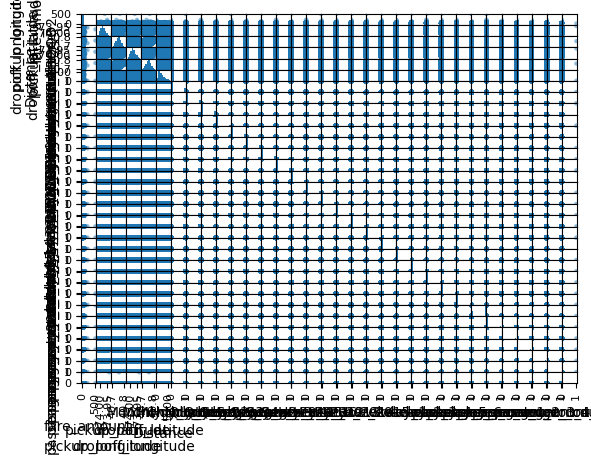

In [ ]:
############### NO EJECUTAR ESTA CELDA
pd.plotting.scatter_matrix(df1);

In [ ]:
############### NO EJECUTAR ESTA CELDA
sns.pairplot(df1)

In [28]:
df1.iloc[:,:-1].corr()

fare_amount  pickup_longitude  pickup_latitude  \
fare_amount            1.000000         -0.041835        -0.061089   
pickup_longitude      -0.041835          1.000000         0.679660   
pickup_latitude       -0.061089          0.679660         1.000000   
dropoff_longitude     -0.018831          0.470291         0.393576   
dropoff_latitude      -0.089354          0.419128         0.592049   
Distance               0.619408         -0.050525        -0.061964   
Monthly_Quarter_Q2     0.005944          0.004609         0.007900   
Monthly_Quarter_Q3     0.003054         -0.018761        -0.021401   
Monthly_Quarter_Q4     0.021407          0.009621         0.012632   
Hourly_Segments_H2    -0.030509          0.017786         0.009301   
Hourly_Segments_H3     0.006481          0.044247         0.056655   
Hourly_Segments_H4     0.017353          0.041752         0.061050   
Hourly_Segments_H5     0.009311          0.027510         0.039281   
Hourly_Segments_H6    -0.009574         -0.056869        -0.063990   
year_2010             -0.057791         -0.000693         0.002654   
year_2011             -0.060372         -0.002962        -0.003518   
year_2012             -0.012829         -0.000974        -0.001394   
year_2013              0.076240         -0.000513        -0.004323   
year_2014              0.093586         -0.005005        -0.002672   
year_2015              0.057083          0.004250         0.004993   
weekday_1             -0.002659          0.015352         0.021987   
weekday_2              0.008935          0.018184         0.022305   
weekday_3              0.015643          0.005098         0.006934   
weekday_4              0.010258         -0.000704         0.000655   
weekday_5             -0.000822         -0.020999        -0.036027   
weekday_6             -0.012915         -0.027105        -0.034782   
passenger_count_1     -0.015482          0.019752         0.018251   
passenger_count_2      0.012735         -0.009999        -0.012554   
passenger_count_3      0.006369         -0.014927        -0.009571   
passenger_count_4      0.006343         -0.015543        -0.013202   
passenger_count_5     -0.005308         -0.001574        -0.001093   
passenger_count_6      0.017032          0.000011         0.000221   

                    dropoff_longitude  dropoff_latitude  Distance  \
fare_amount                 -0.018831         -0.089354  0.619408   
pickup_longitude             0.470291          0.419128 -0.050525   
pickup_latitude              0.393576          0.592049 -0.061964   
dropoff_longitude            1.000000          0.628154  0.014533   
dropoff_latitude             0.628154          1.000000 -0.050955   
Distance                     0.014533         -0.050955  1.000000   
Monthly_Quarter_Q2           0.007101          0.006962  0.008609   
Monthly_Quarter_Q3          -0.022504         -0.022075  0.008952   
Monthly_Quarter_Q4           0.009403          0.010875 -0.001597   
Hourly_Segments_H2           0.017238          0.006384  0.017489   
Hourly_Segments_H3          -0.007961          0.030146 -0.038766   
Hourly_Segments_H4           0.016008          0.052673 -0.052637   
Hourly_Segments_H5           0.011863          0.038132 -0.014904   
Hourly_Segments_H6          -0.018236         -0.052961  0.054782   
year_2010                    0.000327          0.001118 -0.002859   
year_2011                   -0.004189         -0.001203  0.003053   
year_2012                   -0.002716         -0.001460  0.010610   
year_2013                   -0.003305         -0.006331  0.006677   
year_2014                   -0.000438         -0.003402  0.000533   
year_2015                    0.012891          0.007760 -0.006739   
weekday_1                    0.017771          0.021476 -0.010746   
weekday_2                    0.016181          0.018925 -0.012409   
weekday_3                    0.006428          0.007975 -0.005132   
weekday_4                   -0.004477         -0.0041

                                       Correlation Matrix                                       


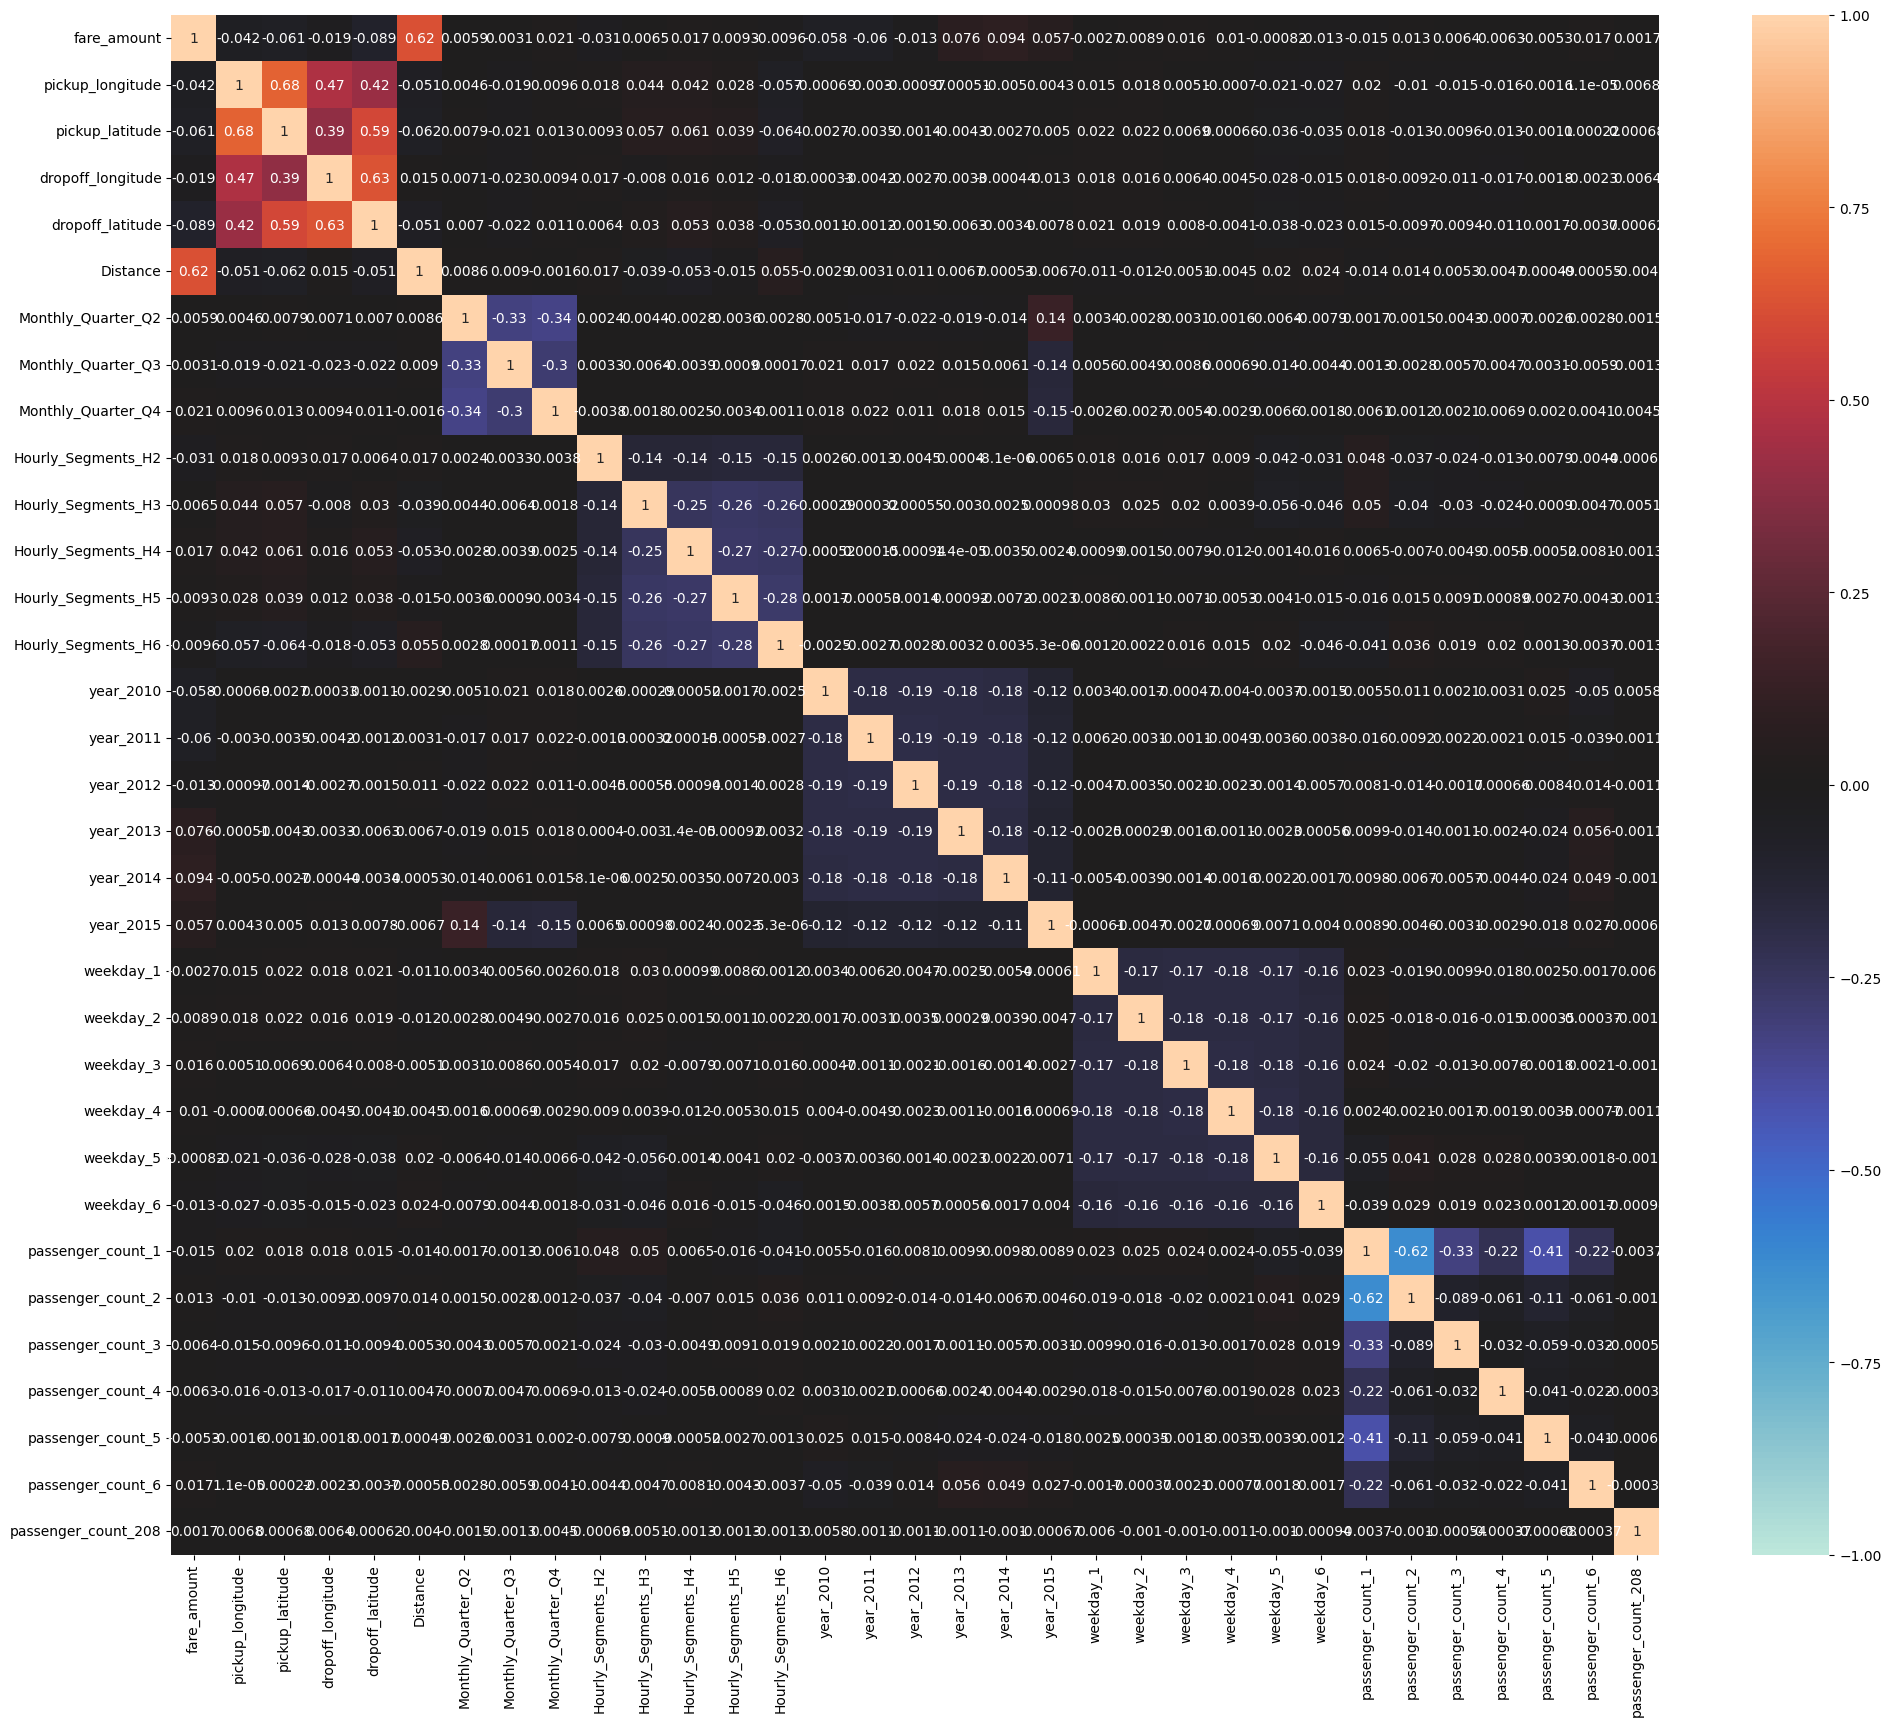

In [29]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df1.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

In [30]:
df1.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'Distance',
       'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4',
       'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4',
       'Hourly_Segments_H5', 'Hourly_Segments_H6', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'passenger_count_208'],
      dtype='object')

In [31]:
df1 = df1.drop(['passenger_count_208'], axis=1)
df1.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4          4.9        -73.969019        40.755910         -73.969019   

   dropoff_latitude  Distance  Monthly_Quarter_Q2  Monthly_Quarter_Q3  \
0         40.723217   1681.11                   1                   0   
1         40.750325   2454.36                   0                   1   
2         40.772647   5039.60                   0                   1   
3         40.803349   1661.44                   1                   0   
4         40.755910      0.00                   0                   0   

   Monthly_Quarter_Q4  Hourly_Segments_H2  ...  weekday_3  weekday_4  \
0                   0                   0  ...          1          0   
1                   0                   0  ...          0          1   
2                   0                   0  ...          0          0   
3                   0                   0  ...          0          1   
4                   0                   0  ...          0          0   

   weekday_5  weekday_6  passenger_count_1  passenger_count_2  \
0          0          0                  1                  0   
1          0          0                  1                  0   
2          0          0                  1                  0   
3          0          0                  0                  0   
4          1          0                  1                  0   

   passenger_count_3  passenger_count_4  passenger_count_5  passenger_count_6  
0                  0                  0                  0                  0  
1                  0                  0                  0                  0  
2                  0                  0                  0                  0  
3                  1                  0                  0                  0  
4                  0                  0                  0                  0  

[5 rows x 32 columns]

### Primer Prueba de modelo. Modelo 1 - TODOS LOS PREDICTORES - NO MODIFICACIONES

Este es el modelo 1, el cual utiliza todos los predictores. No hay interacciones entre los predictores ni variaciones en los predictores.

In [32]:
test_ols = smf.ols('fare_amount ~ Distance + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H2 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + year_2010 + year_2011 + year_2012 + year_2013 + year_2014 + year_2015 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_1 + passenger_count_2 + passenger_count_3 + passenger_count_4 + passenger_count_5 + passenger_count_6', data=df1).fit()
print(test_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     3888.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:30:55   Log-Likelihood:            -4.3119e+05
No. Observations:              163203   AIC:                         8.624e+05
Df Residuals:                  163171   BIC:                         8.628e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1108.2543     81

In [33]:
print("**** Valores P de cada predictor ****")
print(test_ols.pvalues)

**** Valores P de cada predictor ****
Intercept              1.060669e-41
Distance               0.000000e+00
pickup_longitude       6.439177e-02
pickup_latitude        2.638533e-01
dropoff_longitude      2.097791e-11
dropoff_latitude      1.337465e-187
Monthly_Quarter_Q2     7.866004e-14
Monthly_Quarter_Q3     8.535456e-35
Monthly_Quarter_Q4     1.265949e-99
Hourly_Segments_H2     4.976031e-04
Hourly_Segments_H3    1.031242e-128
Hourly_Segments_H4    8.720057e-200
Hourly_Segments_H5    6.509481e-106
Hourly_Segments_H6     7.483366e-04
year_2010              1.278736e-04
year_2011              1.032743e-02
year_2012              3.271928e-68
year_2013              0.000000e+00
year_2014              0.000000e+00
year_2015              0.000000e+00
weekday_1              4.960069e-14
weekday_2              1.209636e-30
weekday_3              8.302907e-38
weekday_4              2.207539e-27
weekday_5              7.197311e-02
weekday_6              1.479329e-04
passenger_count_1      7.0

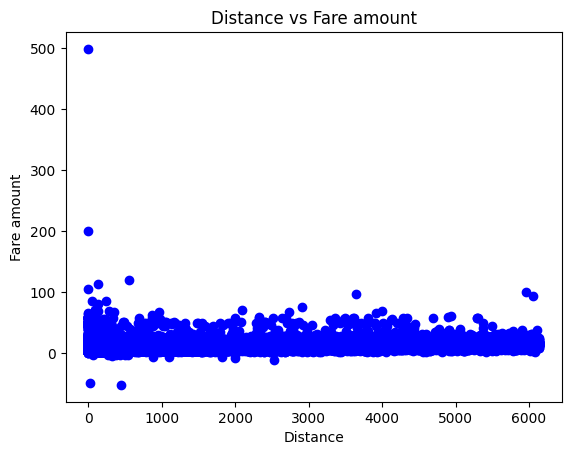

In [34]:
plt.scatter(df1['Distance'], df1['fare_amount'], c='b');
plt.xlabel('Distance')
plt.ylabel('Fare amount')
plt.title('Distance vs Fare amount')
plt.show()

In [35]:
print("Primer prueba de Modelo\n * TODOS LOS PREDICTORES SIN NINGUNA MODIFICACION *\n")
print("R2: ", test_ols.rsquared)
print("R2 ajustado: ", test_ols.rsquared_adj)
print("Estadistico F: ", test_ols.fvalue)

Primer prueba de Modelo
 * TODOS LOS PREDICTORES SIN NINGUNA MODIFICACION *

R2:  0.4248170535065521
R2 ajustado:  0.4247077775240473
Estadistico F:  3887.561052015661


El R2 y el estadístico F tienen buenos valores. Ya que se limpió el dataset eliminando valores duplicados y valores atípicos.

Sin embargo hay alta colinealidad ya que el valor de condición es muy alto.

### Pueba 2 de modelo. Modelo 2 - MODELO SIN dropoff_latitude - SIN INTERACCIONES

En el modelo anterior, el predictor dropoff_latitude presentaba un coeficiente muy negativo, por esa razón se pensó en hacer una prueba de regresión sin utilizar ese predictor.

In [36]:
test_ols_2 = smf.ols('fare_amount ~ Distance + pickup_longitude + pickup_latitude + dropoff_longitude + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H2 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + year_2010 + year_2011 + year_2012 + year_2013 + year_2014 + year_2015 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_1 + passenger_count_2 + passenger_count_3 + passenger_count_4 + passenger_count_5 + passenger_count_6', data=df1).fit()
print(test_ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     3968.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:31:01   Log-Likelihood:            -4.3161e+05
No. Observations:              163203   AIC:                         8.633e+05
Df Residuals:                  163172   BIC:                         8.636e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            218.2032     76

In [37]:
print("MODELO 2")
print("**** Valores P de cada predictor ****")
print(test_ols_2.pvalues)

MODELO 2
**** Valores P de cada predictor ****
Intercept              4.205964e-03
Distance               0.000000e+00
pickup_longitude       1.037401e-11
pickup_latitude        6.691019e-46
dropoff_longitude      5.272925e-30
Monthly_Quarter_Q2     9.013516e-14
Monthly_Quarter_Q3     4.037893e-35
Monthly_Quarter_Q4     5.555261e-99
Hourly_Segments_H2     1.481966e-05
Hourly_Segments_H3    1.474022e-113
Hourly_Segments_H4    1.195860e-178
Hourly_Segments_H5     2.671821e-91
Hourly_Segments_H6     1.104570e-02
year_2010              8.687710e-05
year_2011              9.971295e-03
year_2012              2.605713e-68
year_2013              0.000000e+00
year_2014              0.000000e+00
year_2015              0.000000e+00
weekday_1              4.990743e-14
weekday_2              1.090076e-30
weekday_3              9.191387e-38
weekday_4              8.843346e-28
weekday_5              4.907844e-02
weekday_6              1.304679e-04
passenger_count_1      7.136922e-02
passenger_count_2

In [38]:
print("Prueba 2 de Modelo\n * SIN PREDICTOR dropoff_latitude *\n")
print("R2: ", test_ols_2.rsquared)
print("R2 ajustado: ", test_ols_2.rsquared_adj)
print("Estadistico F: ", test_ols_2.fvalue)

Prueba 2 de Modelo
 * SIN PREDICTOR dropoff_latitude *

R2:  0.42180096498311304
R2 ajustado:  0.4216946601572207
Estadistico F:  3967.8439943098138


El R cuadrada disminuyo un poco, pero el estadistico F aumento un poco, puede que el modelo tenga más significancia con respecto a los predictores, sin embargo que el R cuadrada baje tiene que ver que quitaramos un predictor.

### Pueba 3 de modelo. Modelo 3 - MODELO SIN PREDICTORES DE LONGITUD Y LATITUD - NO INTERACCIONES

Con esta prueba queriamos comrpobar que tanto afecta el modelo tener los datos de longitud y latitud, ya que ya teniamos la distancia.

Sin embargo observamos que en la interpretacion del contexto es que un viaje de uber si toma en cuenta la zona en la que solicitas el viaje y la zona a donde vas.

In [39]:
test_ols_3 = smf.ols('fare_amount ~ Distance + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H2 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + year_2010 + year_2011 + year_2012 + year_2013 + year_2014 + year_2015 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_1 + passenger_count_2 + passenger_count_3 + passenger_count_4 + passenger_count_5 + passenger_count_6', data=df1).fit()
print(test_ols_3.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     4379.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:31:07   Log-Likelihood:            -4.3185e+05
No. Observations:              163203   AIC:                         8.637e+05
Df Residuals:                  163175   BIC:                         8.640e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.0630      0

In [40]:
print("MODELO 3")
print("**** Valores P de cada predictor ****")
print(test_ols_3.pvalues)

MODELO 3
**** Valores P de cada predictor ****
Intercept              4.269024e-44
Distance               0.000000e+00
Monthly_Quarter_Q2     2.170916e-13
Monthly_Quarter_Q3     9.554960e-37
Monthly_Quarter_Q4     6.967821e-97
Hourly_Segments_H2     2.704520e-08
Hourly_Segments_H3    5.406106e-100
Hourly_Segments_H4    8.073063e-159
Hourly_Segments_H5     5.777279e-78
Hourly_Segments_H6     1.102480e-01
year_2010              8.731381e-05
year_2011              7.412608e-03
year_2012              1.078084e-68
year_2013              0.000000e+00
year_2014              0.000000e+00
year_2015              0.000000e+00
weekday_1              9.799184e-14
weekday_2              3.004325e-30
weekday_3              3.546766e-38
weekday_4              1.390619e-28
weekday_5              1.135779e-02
weekday_6              6.018733e-04
passenger_count_1      6.090472e-02
passenger_count_2      3.179688e-03
passenger_count_3      2.806961e-03
passenger_count_4      7.845232e-04
passenger_count_5

In [41]:
print("Prueba 3 de Modelo\n * SIN PREDICTORES DE LONGITUD Y LATITUD *\n")
print("R2: ", test_ols_3.rsquared)
print("R2 ajustado: ", test_ols_3.rsquared_adj)
print("Estadistico F: ", test_ols_3.fvalue)

Prueba 3 de Modelo
 * SIN PREDICTORES DE LONGITUD Y LATITUD *

R2:  0.4201468232224931
R2 ajustado:  0.4200508769330922
Estadistico F:  4378.979383631377


A pesar de que el estadistico F es alto, el R cuadrado es un poco menor, entonces, este modelo tiene una mayor significancia con respecto a los predictores.

### Pueba 4 de modelo. Modelo 4 - MODELO CON PREDICTORES DE LONGITUD Y LATITUD PERO SIN AÑOS - NO INTERACCIONES

Para este modelo regresamos a utilizar los predictores de longitud y latitud, pero esta vez removimos los predictores de años para observar si los años tienen significancia estadística.

In [42]:
test_ols_4 = smf.ols('fare_amount ~ Distance + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_1 + passenger_count_2 + passenger_count_3 + passenger_count_4 + passenger_count_5 + passenger_count_6', data=df1).fit()
print(test_ols_4.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     4508.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:31:14   Log-Likelihood:            -4.3481e+05
No. Observations:              163203   AIC:                         8.697e+05
Df Residuals:                  163178   BIC:                         8.699e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1143.6061     83

Distancia, Latitud y longitud - IMPORTANTES

In [43]:
print("MODELO 4")
print("**** Valores P de cada predictor ****")
print(test_ols_4.pvalues)

MODELO 4
**** Valores P de cada predictor ****
Intercept              1.800267e-42
Distance               0.000000e+00
pickup_longitude       1.588508e-01
pickup_latitude        2.981035e-01
dropoff_longitude      1.716533e-13
dropoff_latitude      4.338551e-187
Monthly_Quarter_Q2     1.155730e-10
Monthly_Quarter_Q3     2.678634e-06
Monthly_Quarter_Q4     2.209875e-42
Hourly_Segments_H3    8.793769e-210
Hourly_Segments_H4     0.000000e+00
Hourly_Segments_H5    1.756579e-175
Hourly_Segments_H6     5.570598e-12
weekday_1              1.000281e-11
weekday_2              5.721736e-29
weekday_3              5.359683e-34
weekday_4              1.097226e-25
weekday_5              3.053633e-02
weekday_6              1.636257e-03
passenger_count_1      1.273692e-07
passenger_count_2      2.430787e-09
passenger_count_3      1.383268e-09
passenger_count_4      5.157294e-10
passenger_count_5      1.957042e-06
passenger_count_6      1.253463e-16
dtype: float64


In [44]:
print("Prueba 4 de Modelo\n * CON PREDICTORES DE LONGITUD Y LATITUD PERO SIN PREDICTORES DE AÑOS *\n")
print("R2: ", test_ols_4.rsquared)
print("R2 ajustado: ", test_ols_4.rsquared_adj)
print("Estadistico F: ", test_ols_4.fvalue)

Prueba 4 de Modelo
 * CON PREDICTORES DE LONGITUD Y LATITUD PERO SIN PREDICTORES DE AÑOS *

R2:  0.39866921359159413
R2 ajustado:  0.3985807706711404
Estadistico F:  4507.644156776577


El estadístico F volvió a aumentar y el R cuadrada volvió a disminuir un poco. Al parecer los predictores de años sí afectan al modelo.

### Pueba 5 de modelo. Modelo 5 - REMOVIENDO year_2010 Y year_2011 - NO INTERACCIONES


In [45]:
test_ols_5 = smf.ols('fare_amount ~ Distance + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H2 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + year_2012 + year_2013 + year_2014 + year_2015 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_1 + passenger_count_2 + passenger_count_3 + passenger_count_4 + passenger_count_5 + passenger_count_6', data=df1).fit()
print(test_ols_5.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     4155.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:31:23   Log-Likelihood:            -4.3119e+05
No. Observations:              163203   AIC:                         8.624e+05
Df Residuals:                  163173   BIC:                         8.627e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1107.6916     81

De acuerdo con el test 1 de regresion lineal, quitamos algunos predictores que suponemos que no hacen mucho sentido para hacer la prediccion.
Los predictores no tomados en cuenta:
* passenger_count_208 > no hace mucho sentido que un viaje tenga 208 pasajeros
* year_2010
* year_2011

De acuerdo con el test del modelo lineal 1, year_2010 y year_2011 tienen coeficientes estimados bajos, esto podria significar que la tarifa de viajes era mas baja en esos años y después aumentó, por lo tanto los descartamos ya que no afectan de manera significativa a la predicción de la tarifa.

### Prueba 6. Modelo 6 - REMOVIENDO ALGUNOS PREDICTORES AL APLICAR VIF - VARIANCE INFLATION FACTOR

VIF es una técnica que funciona para resolver problemas de multicolinealidad. Como en las pruebas de modelos se observan los valores numéricos de condición, entonces existe una alta multicolinealidad. Entonces VIF nos puede ayudar a reducir esto.

Valores muy altos de VIF > 10 pueden indicar multicolinealidad.

In [46]:
df1

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               7.5        -73.999817        40.738354         -73.999512   
1               7.7        -73.994355        40.728225         -73.994710   
2              12.9        -74.005043        40.740770         -73.962565   
3               5.3        -73.976124        40.790844         -73.965316   
4               4.9        -73.969019        40.755910         -73.969019   
...             ...               ...              ...                ...   
163198         12.0        -73.983070        40.760770         -73.972972   
163199          3.0        -73.987042        40.739367         -73.986525   
163200          7.5        -73.984722        40.736837         -74.006672   
163201         14.5        -73.997124        40.725452         -73.983215   
163202         14.1        -73.984395        40.720077         -73.985508   

        dropoff_latitude  Distance  Monthly_Quarter_Q2  Monthly_Quarter_Q3  \
0              40.723217   1681.11                   1                   0   
1              40.750325   2454.36                   0                   1   
2              40.772647   5039.60                   0                   1   
3              40.803349   1661.44                   1                   0   
4              40.755910      0.00                   0                   0   
...                  ...       ...                 ...                 ...   
163198         40.754177   1123.90                   0                   0   
163199         40.740297    112.13                   0                   0   
163200         40.739620   1879.64                   0                   0   
163201         40.695415   3536.55                   1                   0   
163202         40.768793   5410.68                   1                   0   

        Monthly_Quarter_Q4  Hourly_Segments_H2  ...  weekday_3  weekday_4  \
0                        0                   0  ...          1          0   
1                        0                   0  ...          0          1   
2                        0                   0  ...          0          0   
3                        0                   0  ...          0          1   
4                        0                   0  ...          0          0   
...                    ...                 ...  ...        ...        ...   
163198                   0                   0  ...          0          1   
163199                   1                   0  ...          0          0   
163200                   0                   0  ...          0          1   
163201                   0                   0  ...          0          0   
163202                   0                   1  ...          0          0   

        weekday_5  weekday_6  passenger_count_1  passenger_count_2  \
0               0          0                  1                  0   
1               0          0                  1                  0   
2               0          0                  1                  0   
3               0          0                  0                  0   
4               1          0                  1                  0   
...           ...        ...                ...                ...   
163198          0          0                  1                  0   
163199          0          1                  1                  0   
163200          0          0                  1                  0   
163201          0          0                  1                  0   
163202          1          0                  1                  0   

        passenger_count_3  passenger_count_4  passenger_count_5  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       1                  0                  0   
4                       0                  0 

In [47]:
df1.dtypes

fare_amount           float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
Distance              float64
Monthly_Quarter_Q2      uint8
Monthly_Quarter_Q3      uint8
Monthly_Quarter_Q4      uint8
Hourly_Segments_H2      uint8
Hourly_Segments_H3      uint8
Hourly_Segments_H4      uint8
Hourly_Segments_H5      uint8
Hourly_Segments_H6      uint8
year_2010               uint8
year_2011               uint8
year_2012               uint8
year_2013               uint8
year_2014               uint8
year_2015               uint8
weekday_1               uint8
weekday_2               uint8
weekday_3               uint8
weekday_4               uint8
weekday_5               uint8
weekday_6               uint8
passenger_count_1       uint8
passenger_count_2       uint8
passenger_count_3       uint8
passenger_count_4       uint8
passenger_count_5       uint8
passenger_count_6       uint8
dtype: object

In [48]:
X = df1[['Distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4', 'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4', 'Hourly_Segments_H5', 'Hourly_Segments_H6', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'passenger_count_1', 'passenger_count_2', 'passenger_count_3', 'passenger_count_4', 'passenger_count_5', 'passenger_count_6']]

In [49]:
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [50]:
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Variable          VIF
3    dropoff_longitude  28151472.92
1     pickup_longitude  27921884.57
2      pickup_latitude   7151359.88
4     dropoff_latitude   6694737.30
25   passenger_count_1       193.46
26   passenger_count_2        41.41
29   passenger_count_5        20.38
27   passenger_count_3        13.43
28   passenger_count_4         6.98
30   passenger_count_6         6.96
0             Distance         3.69
11  Hourly_Segments_H5         3.49
12  Hourly_Segments_H6         3.39
10  Hourly_Segments_H4         3.28
9   Hourly_Segments_H3         3.21
23           weekday_5         2.24
22           weekday_4         2.24
21           weekday_3         2.21
20           weekday_2         2.17
19           weekday_1         2.14
24           weekday_6         2.05
14           year_2011         2.04
15           year_2012         2.04
5   Monthly_Quarter_Q2         2.02
16           year_2013         2.01
13           year_2010         1.98
17           year_2014         1.97
7   Monthly_Quarter_Q4         1.94
6   Monthly_Quarter_Q3         1.88
8   Hourly_Segments_H2         1.82
18           year_2015         1.52

Para la prueba, haremos una regresion removiendo los predictores que tengan un factor de inflación de varianza

In [51]:
test_ols_6 = smf.ols('fare_amount ~ Distance + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H2 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + year_2010 + year_2011 + year_2012 + year_2013 + year_2014 + year_2015 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_4 + passenger_count_6', data=df1).fit()
print(test_ols_6.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     5136.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:36:01   Log-Likelihood:            -4.3188e+05
No. Observations:              163203   AIC:                         8.638e+05
Df Residuals:                  163179   BIC:                         8.640e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.3687      0

Con respecto al modelo 5, si aumento el R cuadrado y el F estadístico, sin embargo el valor numérico de condición sigue siendo un valor alto, significando que aún existe multicolinealidad entre otros predictores.

Sin embargo, con respecto al contexto, se removieron predictores que hacen lógica para el modelo, por lo tanto, regresaremos a utilizar el modelo 5 pero un poco modificado, esto es, solo eliminando los predictores de longitud y latitud que son los que tienen un factor de inflación de varianza MUY alto.

In [52]:
test_ols_5_2 = smf.ols('fare_amount ~ Distance + Monthly_Quarter_Q2 + Monthly_Quarter_Q3 + Monthly_Quarter_Q4 + Hourly_Segments_H2 + Hourly_Segments_H3 + Hourly_Segments_H4 + Hourly_Segments_H5 + Hourly_Segments_H6 + year_2012 + year_2013 + year_2014 + year_2015 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 + passenger_count_1 + passenger_count_2 + passenger_count_3 + passenger_count_4 + passenger_count_5 + passenger_count_6', data=df1).fit()
print(test_ols_5_2.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     4728.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:36:37   Log-Likelihood:            -4.3185e+05
No. Observations:              163203   AIC:                         8.638e+05
Df Residuals:                  163177   BIC:                         8.640e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.1386      0

Ademas de VIF, aplicamos **Forward selection** (seleccion hacia enfrente) para medir que tan significativas son las variables restantes.

In [124]:
candidate_predictors = ['Distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4', 'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4', 'Hourly_Segments_H5', 'Hourly_Segments_H6', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'passenger_count_1', 'passenger_count_2', 'passenger_count_3', 'passenger_count_4', 'passenger_count_5', 'passenger_count_6']
selected_predictors = []

In [125]:
candidate_predictors = list(X.columns.values)
selected_predictors = list()

In [126]:
while len(candidate_predictors) > 0:
  p_values = []
  predictors_with_p_values = []

  for predictor in candidate_predictors:
    X = df1[selected_predictors + [predictor]]
    X = sm.add_constant(X)
    test_ols_5_3 = sm.OLS(df1['fare_amount'], X).fit()
    p_value = test_ols_5_3.pvalues[predictor]
    p_values.append(p_value)
    predictors_with_p_values.append((predictor, p_value))

  best_predictor, best_p_value = min(predictors_with_p_values, key=lambda x: x[1])

  if best_p_value < 0.05:
    selected_predictors.append(best_predictor)
    candidate_predictors.remove(best_predictor)
  else:
    break

In [127]:
selected_predictors

['Distance',
 'year_2014',
 'year_2013',
 'year_2015',
 'dropoff_latitude',
 'Hourly_Segments_H4',
 'Hourly_Segments_H3',
 'Hourly_Segments_H5',
 'year_2012',
 'Monthly_Quarter_Q4',
 'weekday_6',
 'Monthly_Quarter_Q3',
 'weekday_5',
 'dropoff_longitude',
 'passenger_count_1',
 'Monthly_Quarter_Q2',
 'weekday_3',
 'Hourly_Segments_H2',
 'weekday_2',
 'weekday_4',
 'weekday_1',
 'Hourly_Segments_H6',
 'pickup_longitude',
 'year_2010',
 'year_2011']

In [250]:
X2 = df1[selected_predictors]
X2 = sm.add_constant(X)

In [251]:
model_linear = sm.OLS(df1['fare_amount'], X2).fit()

In [252]:
print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     4819.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:40:31   Log-Likelihood:            -4.3120e+05
No. Observations:              163203   AIC:                         8.624e+05
Df Residuals:                  163177   BIC:                         8.627e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1150.4437     71

In [253]:
# Fare amount predicted based on Model after forward selection

predicted_values = model_linear.predict(X2)
predicted_values

0          9.344291
1          8.085844
2         12.853101
3          6.450702
4          2.437107
            ...    
163198     7.707166
163199     4.419333
163200     8.337120
163201    13.978145
163202    13.403562
Length: 163203, dtype: float64

In [254]:
df1['fare_amount']

0          7.5
1          7.7
2         12.9
3          5.3
4          4.9
          ... 
163198    12.0
163199     3.0
163200     7.5
163201    14.5
163202    14.1
Name: fare_amount, Length: 163203, dtype: float64

In [260]:
R_2_linear = model_linear.rsquared
R_2_linear

0.4247482403719687

### Ridge con todo el dataset

In [134]:
X = df1[selected_predictors]
Y = df1['fare_amount']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [136]:
alphas = np.logspace(-6, 6, 13)
cv_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_scaled, Y, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(scores))

In [137]:
best_alpha = alphas[np.argmax(cv_scores)]
print(f"Best alpha: {best_alpha}")

Best alpha: 10.0


In [138]:
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_scaled, Y)

Ridge(alpha=10.0)

In [144]:
predicted_values_ridge = ridge_best.predict(X_scaled)
predicted_values_ridge

array([ 9.34414437,  8.08605025, 12.85308834, ...,  8.33743962,
       13.97766065, 13.4031874 ])

In [151]:
R2_ridge = r2_score(Y, predicted_values_ridge)
R2_ridge

0.424748237613644

### Lasso con todo el dataset

In [223]:
X = df1[selected_predictors]
Y = df1['fare_amount']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=1.0)
lasso.fit(X_scaled, Y)

Lasso()

In [224]:
predicted_values_lasso = lasso.predict(X_scaled)
predicted_values_lasso

array([ 7.88728032,  8.9057532 , 12.31085738, ...,  8.14877068,
       10.33114105, 12.79961899])

In [225]:
R2_lasso = r2_score(Y, predicted_values_lasso)
R2_lasso

0.33384178878868276

### Polinomial con todo el dataset, grado 2

In [234]:
X = df1[selected_predictors]
Y = df1['fare_amount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
linear = LinearRegression(fit_intercept=True)
linear.fit(X_poly, Y)
predicted_values_poly_2 = linear.predict(X_poly)
mse = mean_squared_error(Y, predicted_values_poly_2)
R_2_poly_2 = linear.score(X_poly, Y)

print(f"Mean Squared Error: {mse}")
print(f"R_square: {R_2_poly_2}")

Mean Squared Error: 10.846207514837443
R_square: 0.45958745999423267


In [235]:
predicted_values_poly_2

array([ 9.14306641,  7.90136719, 12.14892578, ...,  8.50732422,
       15.46630859, 10.87304688])

### Polinomial con todo el dataset, grado 3

In [344]:
X = df1[selected_predictors]
Y = df1['fare_amount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
poly_3 = PolynomialFeatures(degree=3)
X_poly = poly_3.fit_transform(X_scaled)
linear = LinearRegression(fit_intercept=True)
linear.fit(X_poly, Y)
predicted_values_poly_3 = linear.predict(X_poly)
mse = mean_squared_error(Y, predicted_values_poly_3)
R_2_poly_3 = linear.score(X_poly, Y)

print(f"Mean Squared Error: {mse}")
print(f"R_square: {R_2_poly_3}")

Mean Squared Error: 10.26909070874744
R_square: 0.4883423181907467


In [238]:
predicted_values_poly_3

array([ 8.62246704,  7.27432251, 12.16641235, ...,  8.59854126,
       16.26211548, 12.32510376])

### Linear con split de dataset en train y test

In [181]:
X = df1[selected_predictors]
Y = df1['fare_amount']

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

linear = LinearRegression(fit_intercept=True)
linear.fit(X_train, Y_train)

predicted_values_linear_2 = linear.predict(X_test)
mse_linear_split = mean_squared_error(Y_test, predicted_values_linear_2)
R_2_linear_split = linear.score(X_test, Y_test)
print(f"Mean Squared Error: {mse_linear_split}")
print(f"R_square: {R_2_linear_split}")

Mean Squared Error: 9.273014538849756
R_square: 0.481335986832507


In [183]:
predicted_values_linear_2

array([7.81598122, 7.65155134, 7.71765434, ..., 9.49793583, 4.0097299 ,
       6.1772695 ])

### Ridge con split de dataset en train y test

In [182]:
X = df1[selected_predictors]
Y = df1['fare_amount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=best_alpha)

ridge.fit(X_train, Y_train)

predicted_values_ridge_2 = ridge.predict(X_test)
mse = mean_squared_error(Y_test, predicted_values_ridge_2)
R_2_ridge_split = ridge.score(X_test, Y_test)
print(f"Mean Squared Error: {mse}")
print(f"R_square: {R_2_ridge_split}")

Mean Squared Error: 9.273015984841136
R_square: 0.4813359059544182


In [167]:
predicted_values_ridge_2

array([7.81591765, 7.65158369, 7.71769902, ..., 9.49774752, 4.00997864,
       6.17730277])

### Lasso Regression con split de dataset en train y test

In [197]:
X = df1[selected_predictors]
Y = df1['fare_amount']
scaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled, Y_train)

predicted_values_lasso_split = lasso.predict(X_test_scaled)
mse = mean_squared_error(Y_test, predicted_values_lasso_split)
R_2_lasso_split = lasso.score(X_test_scaled, Y_test)

print(f"Mean Squared Error: {mse}")
print(f"R_square: {R_2_lasso_split}")

Mean Squared Error: 17.878705262056343
R_square: -2.855878964869163e-06


### Polynomial Regression con split de dataset en train y test, grado 2

In [202]:
X = df1[selected_predictors]
Y = df1['fare_amount']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
linear = LinearRegression()
linear.fit(X_train_poly, Y_train)
predicted_values_poly_split_2 = linear.predict(X_test_poly)
mse = mean_squared_error(Y_test, predicted_values_poly_split_2)
R_2_poly_split = linear.score(X_test_poly, Y_test)

print(f"Mean Squared Error: {mse}")
print(f"R_square: {R_2_poly_split}")

Mean Squared Error: 8.677210361353817
R_square: 0.5146608764320366


In [203]:
predicted_values_poly_split_2

array([8.49023438, 8.07421875, 7.58203125, ..., 9.2421875 , 4.5234375 ,
       6.11523438])

### Polynomial Regression con split de dataset en train y test, grado 3

In [209]:
X = df1[selected_predictors]
Y = df1['fare_amount']

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
linear = LinearRegression()
linear.fit(X_train_poly, Y_train)
predicted_values_poly_split_3 = linear.predict(X_test_poly)
mse = mean_squared_error(Y_test, predicted_values_poly_split_3)
R_2_poly_split_3 = linear.score(X_test_poly, Y_test)

print(f"Mean Squared Error: {mse}")
print(f"R_square: {R_2_poly_split_3}")

Mean Squared Error: 8.472715035151866
R_square: 0.5260988361286959


In [210]:
predicted_values_poly_split_3

array([8.18954468, 8.11923218, 7.59237671, ..., 9.59872437, 4.60614014,
       6.80340576])

In [114]:
df1[selected_predictors]

Distance  year_2014  year_2013  year_2015  dropoff_latitude  \
0        1681.11          0          0          1         40.723217   
1        2454.36          0          0          0         40.750325   
2        5039.60          0          0          0         40.772647   
3        1661.44          0          0          0         40.803349   
4           0.00          0          0          0         40.755910   
...          ...        ...        ...        ...               ...   
163198   1123.90          1          0          0         40.754177   
163199    112.13          0          0          0         40.740297   
163200   1879.64          1          0          0         40.739620   
163201   3536.55          0          0          1         40.695415   
163202   5410.68          0          0          0         40.768793   

        Hourly_Segments_H4  Hourly_Segments_H3  Hourly_Segments_H5  year_2012  \
0                        0                   0                   1          0   
1                        0                   0                   0          0   
2                        0                   0                   0          0   
3                        0                   1                   0          0   
4                        0                   0                   0          0   
...                    ...                 ...                 ...        ...   
163198                   1                   0                   0          0   
163199                   0                   1                   0          1   
163200                   0                   0                   0          0   
163201                   1                   0                   0          0   
163202                   0                   0                   0          0   

        Monthly_Quarter_Q4  ...  Monthly_Quarter_Q2  weekday_3  \
0                        0  ...                   1          1   
1                        0  ...                   0          0   
2                        0  ...                   0          0   
3                        0  ...                   1          0   
4                        0  ...                   0          0   
...                    ...  ...                 ...        ...   
163198                   0  ...                   0          0   
163199                   1  ...                   0          0   
163200                   0  ...                   0          0   
163201                   0  ...                   1          0   
163202                   0  ...                   1          0   

        Hourly_Segments_H2  weekday_2  weekday_4  weekday_1  \
0                        0          0          0          0   
1                        0          0          1          0   
2                        0          0          0          0   
3                        0          0          1          0   
4                        0          0          0          0   
...                    ...        ...        ...        ...   
163198                   0          0          1          0   
163199                   0          0          0          0   
163200                   0          0          1          0   
163201                   0          1          0          0   
163202                   1          0          0          0   

        Hourly_Segments_H6  pickup_longitude  year_2010  year_2011  
0                        0        -73.999817          0          0  
1                        1        -73.994355          0          0  
2                        1        -74.005043          0          0  
3                        0        -73.976124          0          0  
4                        0        -73.969019          0          1  
...                    ...               ...        ...        ...  
163198                   0        -73.983070          0          0  
163199                   0        -73.987042          0          0  
163200     

In [211]:
df_results_split = pd.DataFrame({'Actual_split': Y_test, 'Predicted_linear_split': predicted_values_linear_2, 'Predicted_ridge_split': predicted_values_ridge_2, 'Predicted_poly_split_2': predicted_values_poly_split_2, 'Predicted_poly_split_3': predicted_values_poly_split_3})

In [212]:
df_results_split

Actual_split  Predicted_linear_split  Predicted_ridge_split  \
20811            6.5                7.815981               7.815918   
118479          17.0                7.651551               7.651584   
120487           7.0                7.717654               7.717699   
154325          10.9                9.682072               9.681809   
106941           9.5               11.682257              11.682322   
...              ...                     ...                    ...   
102505           9.3                6.940846               6.941176   
139220           4.5                5.562356               5.562460   
121437           6.5                9.497936               9.497748   
27542            3.3                4.009730               4.009979   
20506            5.7                6.177269               6.177303   

        Predicted_poly_split_2  Predicted_poly_split_3  
20811                 8.490234                8.189545  
118479                8.074219                8.119232  
120487                7.582031                7.592377  
154325                8.542969                8.811829  
106941               10.871094               11.248138  
...                        ...                     ...  
102505                7.601562                7.056946  
139220                5.691406                6.121399  
121437                9.242188                9.598724  
27542                 4.523438                4.606140  
20506                 6.115234                6.803406  

[32641 rows x 5 columns]

In [239]:
df_results = pd.DataFrame({'Actual': df1['fare_amount'], 'Predicted_linear': predicted_values, 'Predicted_ridge': predicted_values_ridge, 'Predicted_lasso': predicted_values_lasso, 'Predicted_poly_2': predicted_values_poly_2, 'Predicted_poly_3': predicted_values_poly_3})

In [241]:
df_results['Error_linear'] = np.abs(df_results['Actual'] - df_results['Predicted_linear'])
df_results['Error_ridge'] = np.abs(df_results['Actual'] - df_results['Predicted_ridge'])
df_results['Error_lasso'] = np.abs(df_results['Actual'] - df_results['Predicted_lasso'])
df_results['Error_poly_2'] = np.abs(df_results['Actual'] - df_results['Predicted_poly_2'])
df_results['Error_poly_3'] = np.abs(df_results['Actual'] - df_results['Predicted_poly_3'])
df_results

Actual  Predicted_linear  Predicted_ridge  Predicted_lasso  \
0          7.5          9.345956         9.344144         7.887280   
1          7.7          8.083534         8.086050         8.905753   
2         12.9         12.850677        12.853088        12.310857   
3          5.3          6.456325         6.450998         7.861372   
4          4.9          2.434956         2.437733         5.673035   
...        ...               ...              ...              ...   
163198    12.0          7.709066         7.707170         7.153361   
163199     3.0          4.420287         4.419458         5.820725   
163200     7.5          8.338346         8.337440         8.148771   
163201    14.5         13.980250        13.977661        10.331141   
163202    14.1         13.401531        13.403187        12.799619   

        Predicted_poly_2  Predicted_poly_3  Error_linear  Error_ridge  \
0               9.143066          8.622467      1.845956     1.844144   
1               7.901367          7.274323      0.383534     0.386050   
2              12.148926         12.166412      0.049323     0.046912   
3               6.406738          6.146881      1.156325     1.150998   
4               4.786133          5.164459      2.465044     2.462267   
...                  ...               ...           ...          ...   
163198          7.496582          7.446686      4.290934     4.292830   
163199          4.890137          5.352936      1.420287     1.419458   
163200          8.507324          8.598541      0.838346     0.837440   
163201         15.466309         16.262115      0.519750     0.522339   
163202         10.873047         12.325104      0.698469     0.696813   

        Error_lasso  Error_poly_2  Error_poly_3  
0          0.387280      1.643066      1.122467  
1          1.205753      0.201367      0.425677  
2          0.589143      0.751074      0.733588  
3          2.561372      1.106738      0.846881  
4          0.773035      0.113867      0.264459  
...             ...           ...           ...  
163198     4.846639      4.503418      4.553314  
163199     2.820725      1.890137      2.352936  
163200     0.648771      1.007324      1.098541  
163201     4.168859      0.966309      1.762115  
163202     1.300381      3.226953      1.774896  

[163203 rows x 11 columns]

In [276]:
R_square_full = [R_2_linear, R2_ridge, R2_lasso, R_2_poly_2, R_2_poly_3]
R_square_split = [R_2_linear_split, R_2_ridge_split, R_2_lasso_split, R_2_poly_split, R_2_poly_split_3]

In [277]:
df_R = pd.DataFrame({'R_square_Full': R_square_full, 'R_square_Split': R_square_split})
df_R.index = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Polynomial Regression deg 2', 'Polynomial Regression deg 3']
df_R

R_square_Full  R_square_Split
Linear Regression                 0.424748        0.481336
Ridge Regression                  0.424748        0.481336
Lasso Regression                  0.333842       -0.000003
Polynomial Regression deg 2       0.459587        0.514661
Polynomial Regression deg 3       0.488342        0.526099

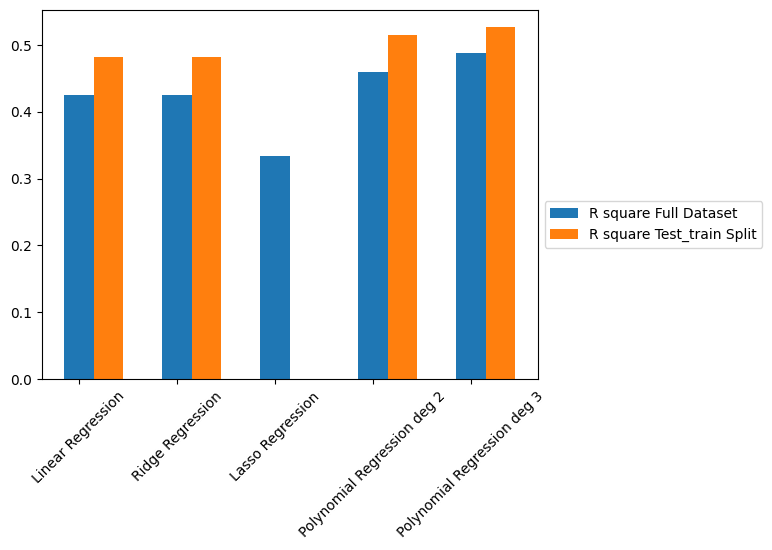

In [313]:
plt.bar(np.arange(5), df_R.R_square_Full.values, width=0.3, label = 'R square Full Dataset')
plt.bar(np.arange(5)+0.3 ,df_R.R_square_Split.values, width=0.3, label= 'R square Test_train Split')
plt.xticks(np.arange(5), df_R.index, rotation=45)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

In [338]:
def get_hour_segment(row):
    for col in row.index:
        if "Hourly_Segments" in col and row[col] == 1:
            return int(col.split('_')[-1][1:])
    return 1

In [339]:
hour_segments_cols = [col for col in df1.columns if "Hourly_Segments" in col]
df1['Hour_Segment'] = df1[hour_segments_cols].apply(get_hour_segment, axis=1)

In [340]:
df_results_f = pd.DataFrame({'Real_Fare': df1['fare_amount'],'Predicted':predicted_values_poly_3, 'Distance': df1['Distance'], 'Hour_Segment': df1['Hour_Segment']})
df_results_f

Real_Fare  Predicted  Distance  Hour_Segment
0             7.5   8.622467   1681.11             5
1             7.7   7.274323   2454.36             6
2            12.9  12.166412   5039.60             6
3             5.3   6.146881   1661.44             3
4             4.9   5.164459      0.00             1
...           ...        ...       ...           ...
163198       12.0   7.446686   1123.90             4
163199        3.0   5.352936    112.13             3
163200        7.5   8.598541   1879.64             1
163201       14.5  16.262115   3536.55             4
163202       14.1  12.325104   5410.68             2

[163203 rows x 4 columns]

In [343]:
df_results_f.to_csv('./data/predictions.csv', index=False)